# Applying the XGBoost Algorithm

For showing the decision tree by using plot_tree the package graphviz is required.
Download for Mac by using brew install graphviz in the terminal.

## Import and Setup

In [16]:
# Import moduls
from xgboost import XGBClassifier, plot_tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import graphviz

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score

plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

RSEED=1234

In [17]:
# Read data
df = pd.read_csv("../data/ChatGPT-play-reviews_sentiment.csv")

In [18]:
for var in ['score_cat', 'category', 'vader_cat', 'pipe_cat']:
    df[var] = df[var].astype('category')
    df[var+"_num"] = df[var].cat.codes

In [19]:
# Split the data
y = df['score_cat_num']
X = df[['category_num', 'positive_score', 'neutral_score', 'negative_score', 'vader_cat_num', 'vader_neg', 'vader_neu', 'vader_pos',
       'blob_polarity', 'blob_subjectivity', 'pipe_cat_num', 'pipe_neg']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RSEED)

In [20]:
y_train.shape, y_test.shape

((14946,), (6406,))

In [21]:
X_train.dtypes

category_num            int8
positive_score       float64
neutral_score        float64
negative_score       float64
vader_cat_num           int8
vader_neg            float64
vader_neu            float64
vader_pos            float64
blob_polarity        float64
blob_subjectivity    float64
pipe_cat_num            int8
pipe_neg             float64
dtype: object

In [36]:
# Fit model to training data
bst = XGBClassifier(random_state=RSEED,
                    n_jobs=-1,
                    eval_metric='mape',
                    max_depth = 4) #n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'
# fit model
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mape', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [37]:
# Make predictions on test set 
y_test_predicted = bst.predict(X_test)

In [38]:
# Evaluate your model 
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted, average="weighted")))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted, average="weighted")))

Accuracy: 0.82
Recall: 0.82
Precision: 0.78


In [39]:
# Evaluate your model
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1101
           1       0.41      0.07      0.12       742
           2       0.84      0.96      0.90      4563

    accuracy                           0.82      6406
   macro avg       0.67      0.59      0.59      6406
weighted avg       0.78      0.82      0.78      6406



In [47]:
#extract the most important features from the model
imp = list(zip(bst.feature_names_in_,bst.feature_importances_))
#imp.sort(key = lambda tuple:tuple[1],reverse= True)
imp

[('category_num', 0.9141411),
 ('positive_score', 0.013433526),
 ('neutral_score', 0.0044285217),
 ('negative_score', 0.008265669),
 ('vader_cat_num', 0.00339472),
 ('vader_neg', 0.0030814516),
 ('vader_neu', 0.0032834825),
 ('vader_pos', 0.0035332202),
 ('blob_polarity', 0.0039212233),
 ('blob_subjectivity', 0.004345311),
 ('pipe_cat_num', 0.030393563),
 ('pipe_neg', 0.0077781165)]

In [49]:
bst.get_booster().get_score(importance_type='gain')

{'category_num': 510.4862060546875,
 'positive_score': 7.5017194747924805,
 'neutral_score': 2.4730310440063477,
 'negative_score': 4.615819454193115,
 'vader_cat_num': 1.8957223892211914,
 'vader_neg': 1.7207831144332886,
 'vader_neu': 1.8336037397384644,
 'vader_pos': 1.9730653762817383,
 'blob_polarity': 2.1897389888763428,
 'blob_subjectivity': 2.426563262939453,
 'pipe_cat_num': 16.97275733947754,
 'pipe_neg': 4.3435540199279785}

<Axes: >

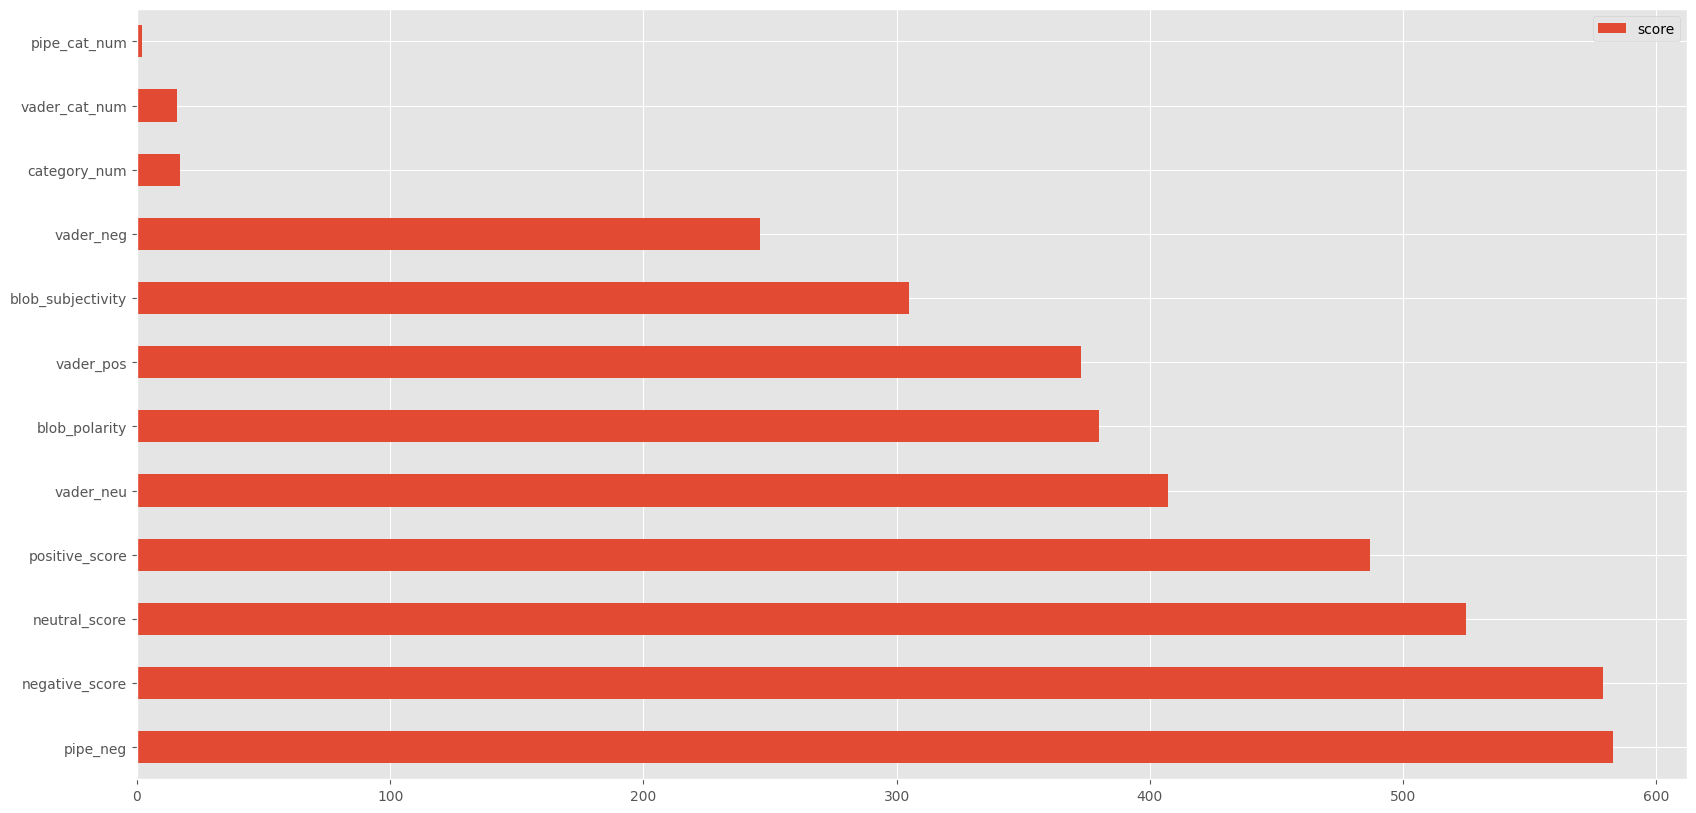

In [50]:
feature_important = bst.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

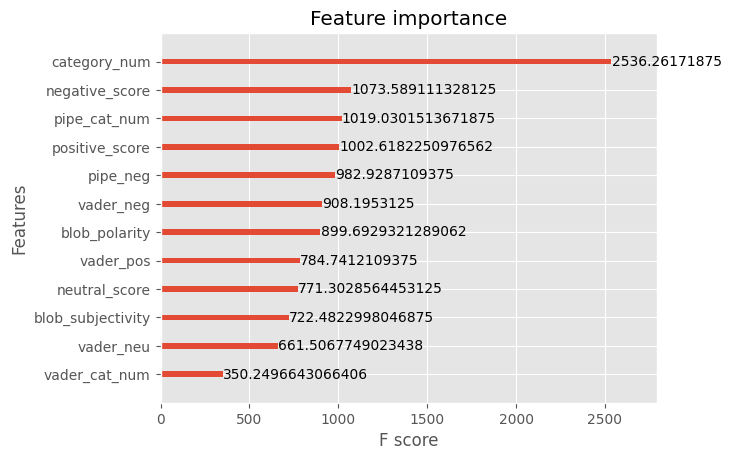

In [60]:
from xgboost import plot_importance
plot_importance(bst, importance_type='cover')
plt.show()

<Axes: >

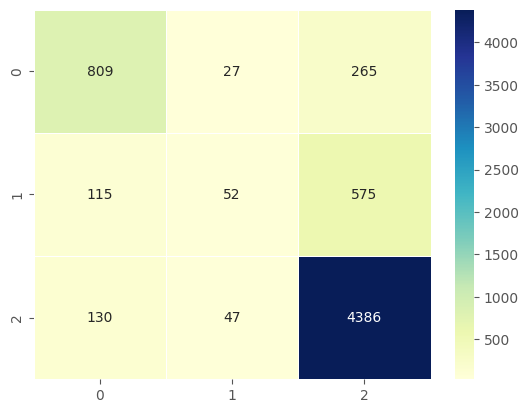

In [41]:
# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_test_predicted)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)

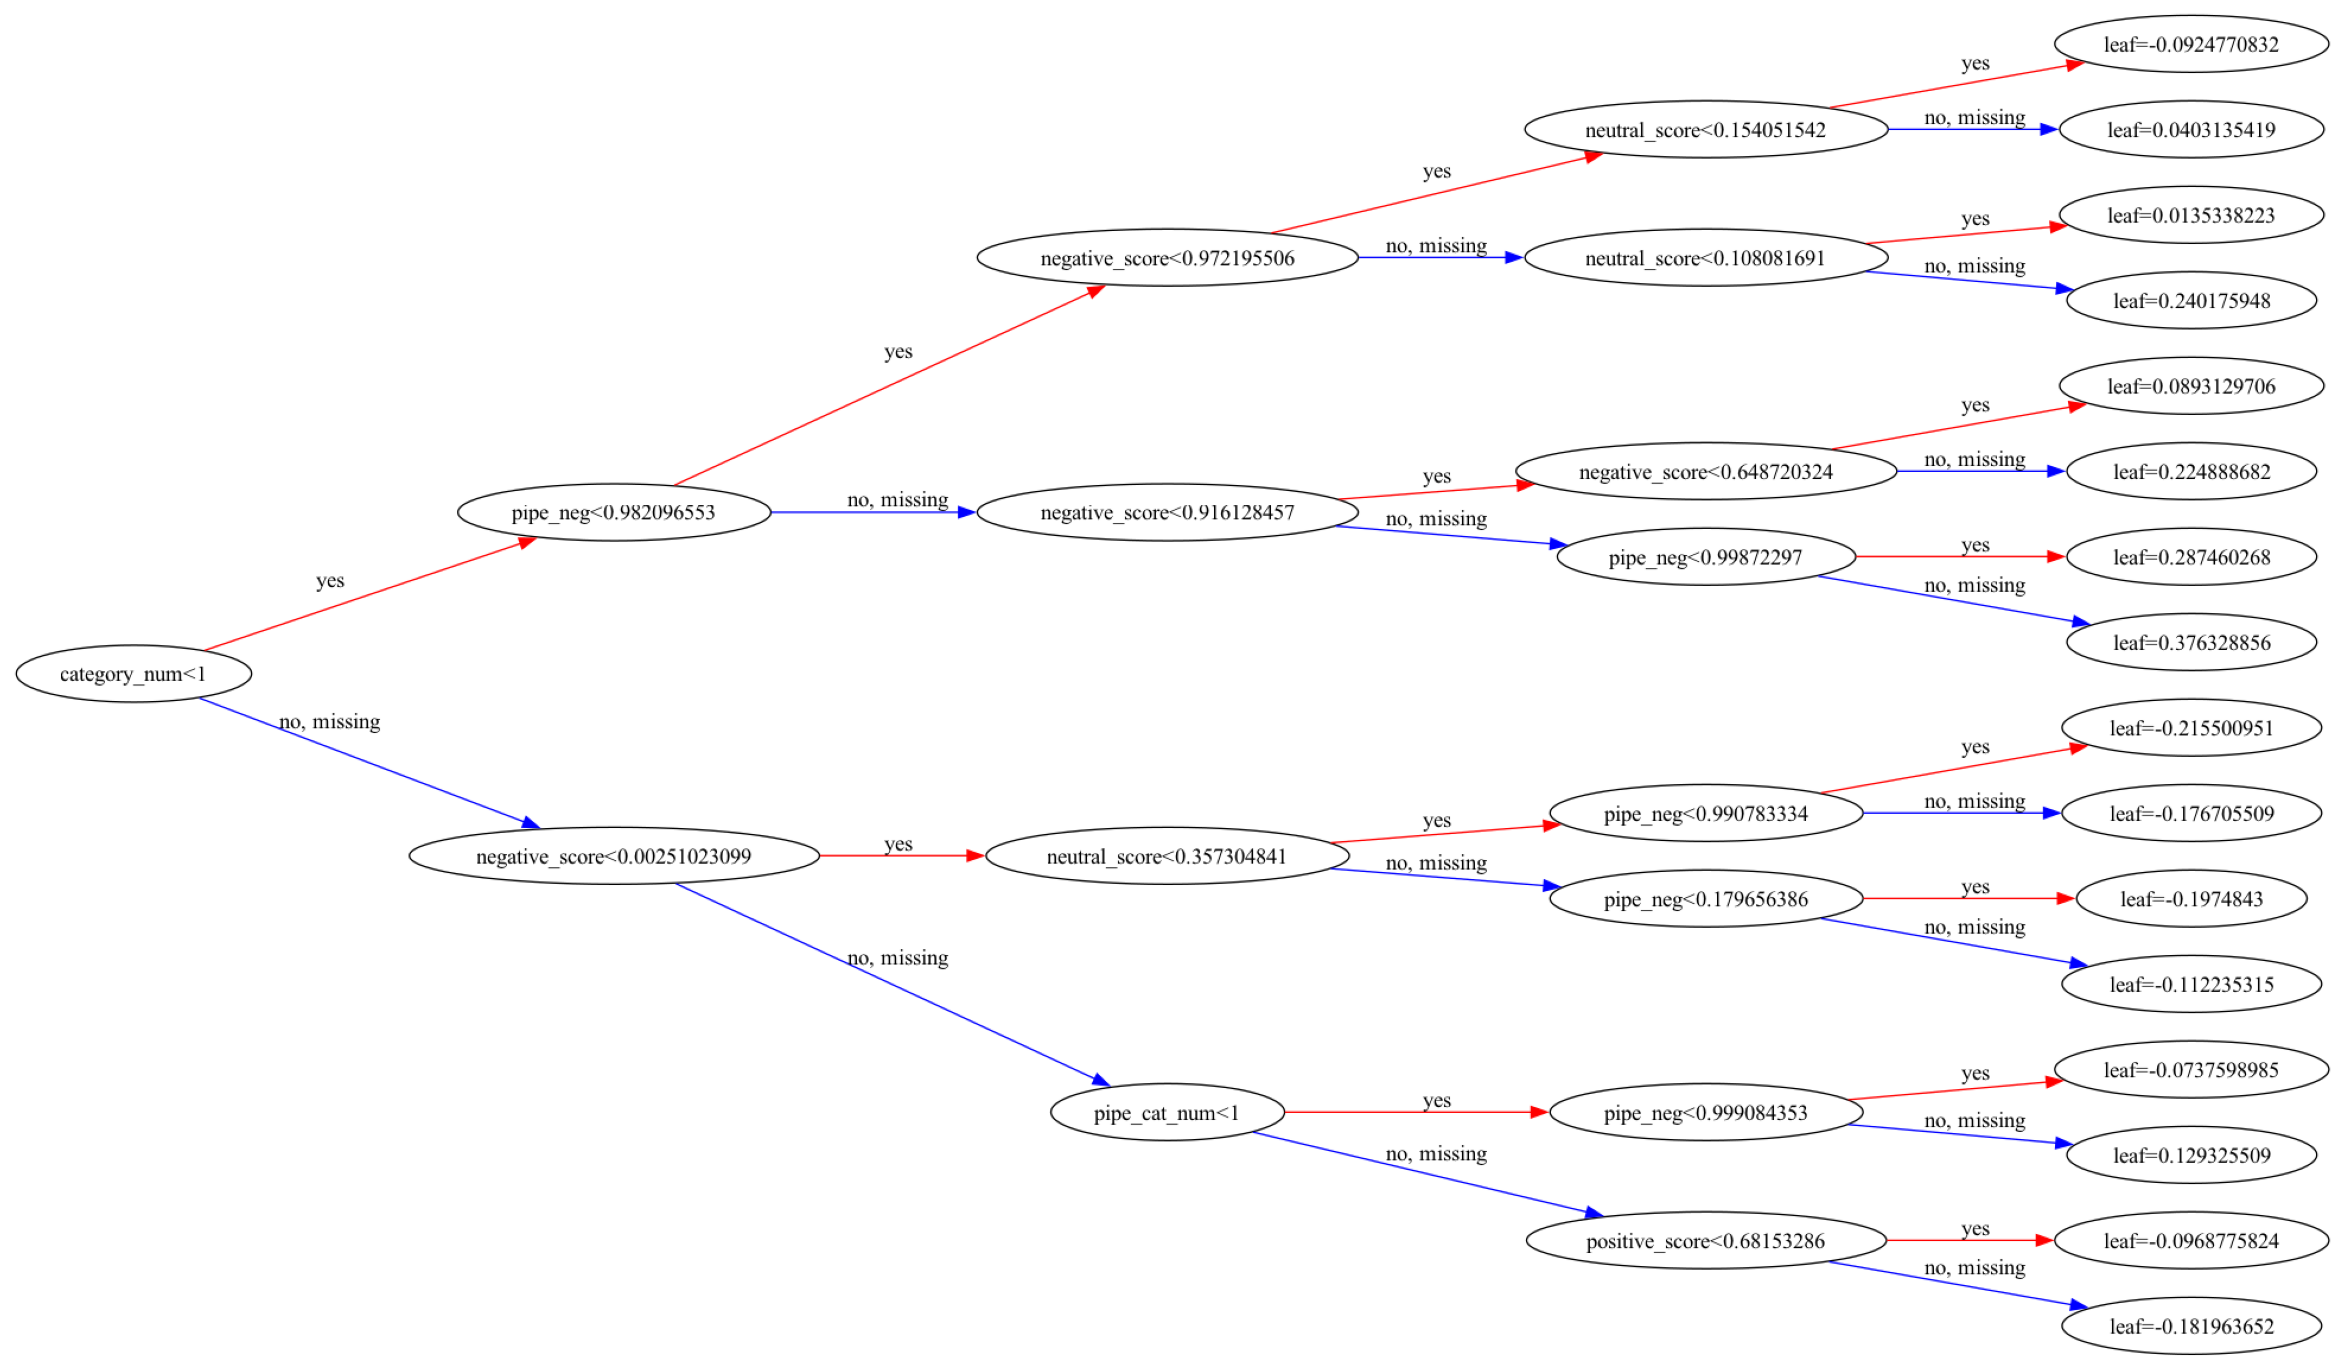

In [52]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(bst, 
          ax=ax, rankdir='LR')
plt.show()

In [ ]:
bst.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 1234,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [53]:
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [1, 2, 3, 4, 5],
        'learning_rate': [0.1, 0.2, 0.5, 1, 2, 5, 10],
        'n_estimators': [1, 10, 100, 1000],
        'objective': ['multi:softmax', 'multi:softprob']
        }

xgb = XGBClassifier(
                   ) #learning_rate=0.02, silent=True, nthread=1 objective='multi:softprob'


In [54]:
folds = 10
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = RSEED)

random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=params, 
                                   n_iter=100, 
                                   scoring='accuracy', # scoring='roc_auc', 'accuracy'
                                   n_jobs=-1, cv=skf.split(X_train,y_train),
                                   verbose=3, 
                                   random_state=RSEED)

# Fit the model
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 7/10] END colsample_bytree=1.0, gamma=0.5, learning_rate=10, max_depth=2, min_child_weight=1, n_estimators=10, objective=multi:softmax, subsample=0.8;, score=0.116 total time=   0.1s
[CV 1/10] END colsample_bytree=1.0, gamma=0.5, learning_rate=10, max_depth=2, min_child_weight=1, n_estimators=10, objective=multi:softmax, subsample=0.8;, score=0.114 total time=   0.1s
[CV 8/10] END colsample_bytree=1.0, gamma=0.5, learning_rate=10, max_depth=2, min_child_weight=1, n_estimators=10, objective=multi:softmax, subsample=0.8;, score=0.116 total time=   0.1s
[CV 4/10] END colsample_bytree=1.0, gamma=0.5, learning_rate=10, max_depth=2, min_child_weight=1, n_estimators=10, objective=multi:softmax, subsample=0.8;, score=0.116 total time=   0.1s
[CV 3/10] END colsample_bytree=1.0, gamma=0.5, learning_rate=10, max_depth=2, min_child_weight=1, n_estimators=10, objective=multi:softmax, subsample=0.8;, score=0.124 total time=   0.1s


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x28ab7cca0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=No...
                                           random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.1, 0.2, 0.5, 1, 2,
                                                          5, 10],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [1, 10, 100, 1000],
                                        'objective': ['multi:softmax',
                                                      'multi:softprob'],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1234, scoring='accuracy', verbose=3)

In [55]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'mean_fit_time': array([0.09621587, 0.19280624, 3.98152838, 0.09429731, 3.50574248,
       0.40606117, 5.05826702, 0.53604493, 0.05491247, 0.43622203,
       3.60922153, 4.24157233, 0.08332465, 0.0986748 , 0.5398911 ,
       0.79510665, 0.05721917, 0.42399211, 0.12710247, 0.12037857,
       3.40051167, 0.05798745, 0.38908007, 0.08528738, 0.45513983,
       0.04777169, 0.13102496, 0.09619622, 0.45735059, 4.4010541 ,
       4.14867392, 0.05127125, 0.05959024, 4.72730162, 0.05591636,
       0.04954545, 4.32944577, 0.04929988, 5.38413873, 0.14506402,
       0.10074441, 0.05716054, 0.56575332, 4.85341015, 0.07852371,
       0.06435664, 5.87894156, 0.58349581, 0.85408628, 0.0595933 ,
       4.33452411, 0.06400368, 0.05536389, 0.9873095 , 0.4957612 ,
       0.13843751, 0.11355438, 0.45441642, 0.44724858, 0.05090373,
       0.51607177, 0.05031981, 0.04819059, 0.89126518, 0.4514195 ,
       0.05496628, 0.46526163, 0.37274387, 4.23054705, 0.05740631,
       0.13221912, 0.56297059

In [56]:
# Save best estimator (including fitted preprocessing steps) as best_model 
best_model = random_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [57]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = best_model.predict(X_test)

# Evaluate your model 
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted, average="weighted")))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted, average="weighted")))

Accuracy: 0.82
Recall: 0.82
Precision: 0.77


In [58]:
# Evaluate your model
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1101
           1       0.40      0.04      0.08       742
           2       0.84      0.96      0.90      4563

    accuracy                           0.82      6406
   macro avg       0.67      0.58      0.58      6406
weighted avg       0.77      0.82      0.78      6406



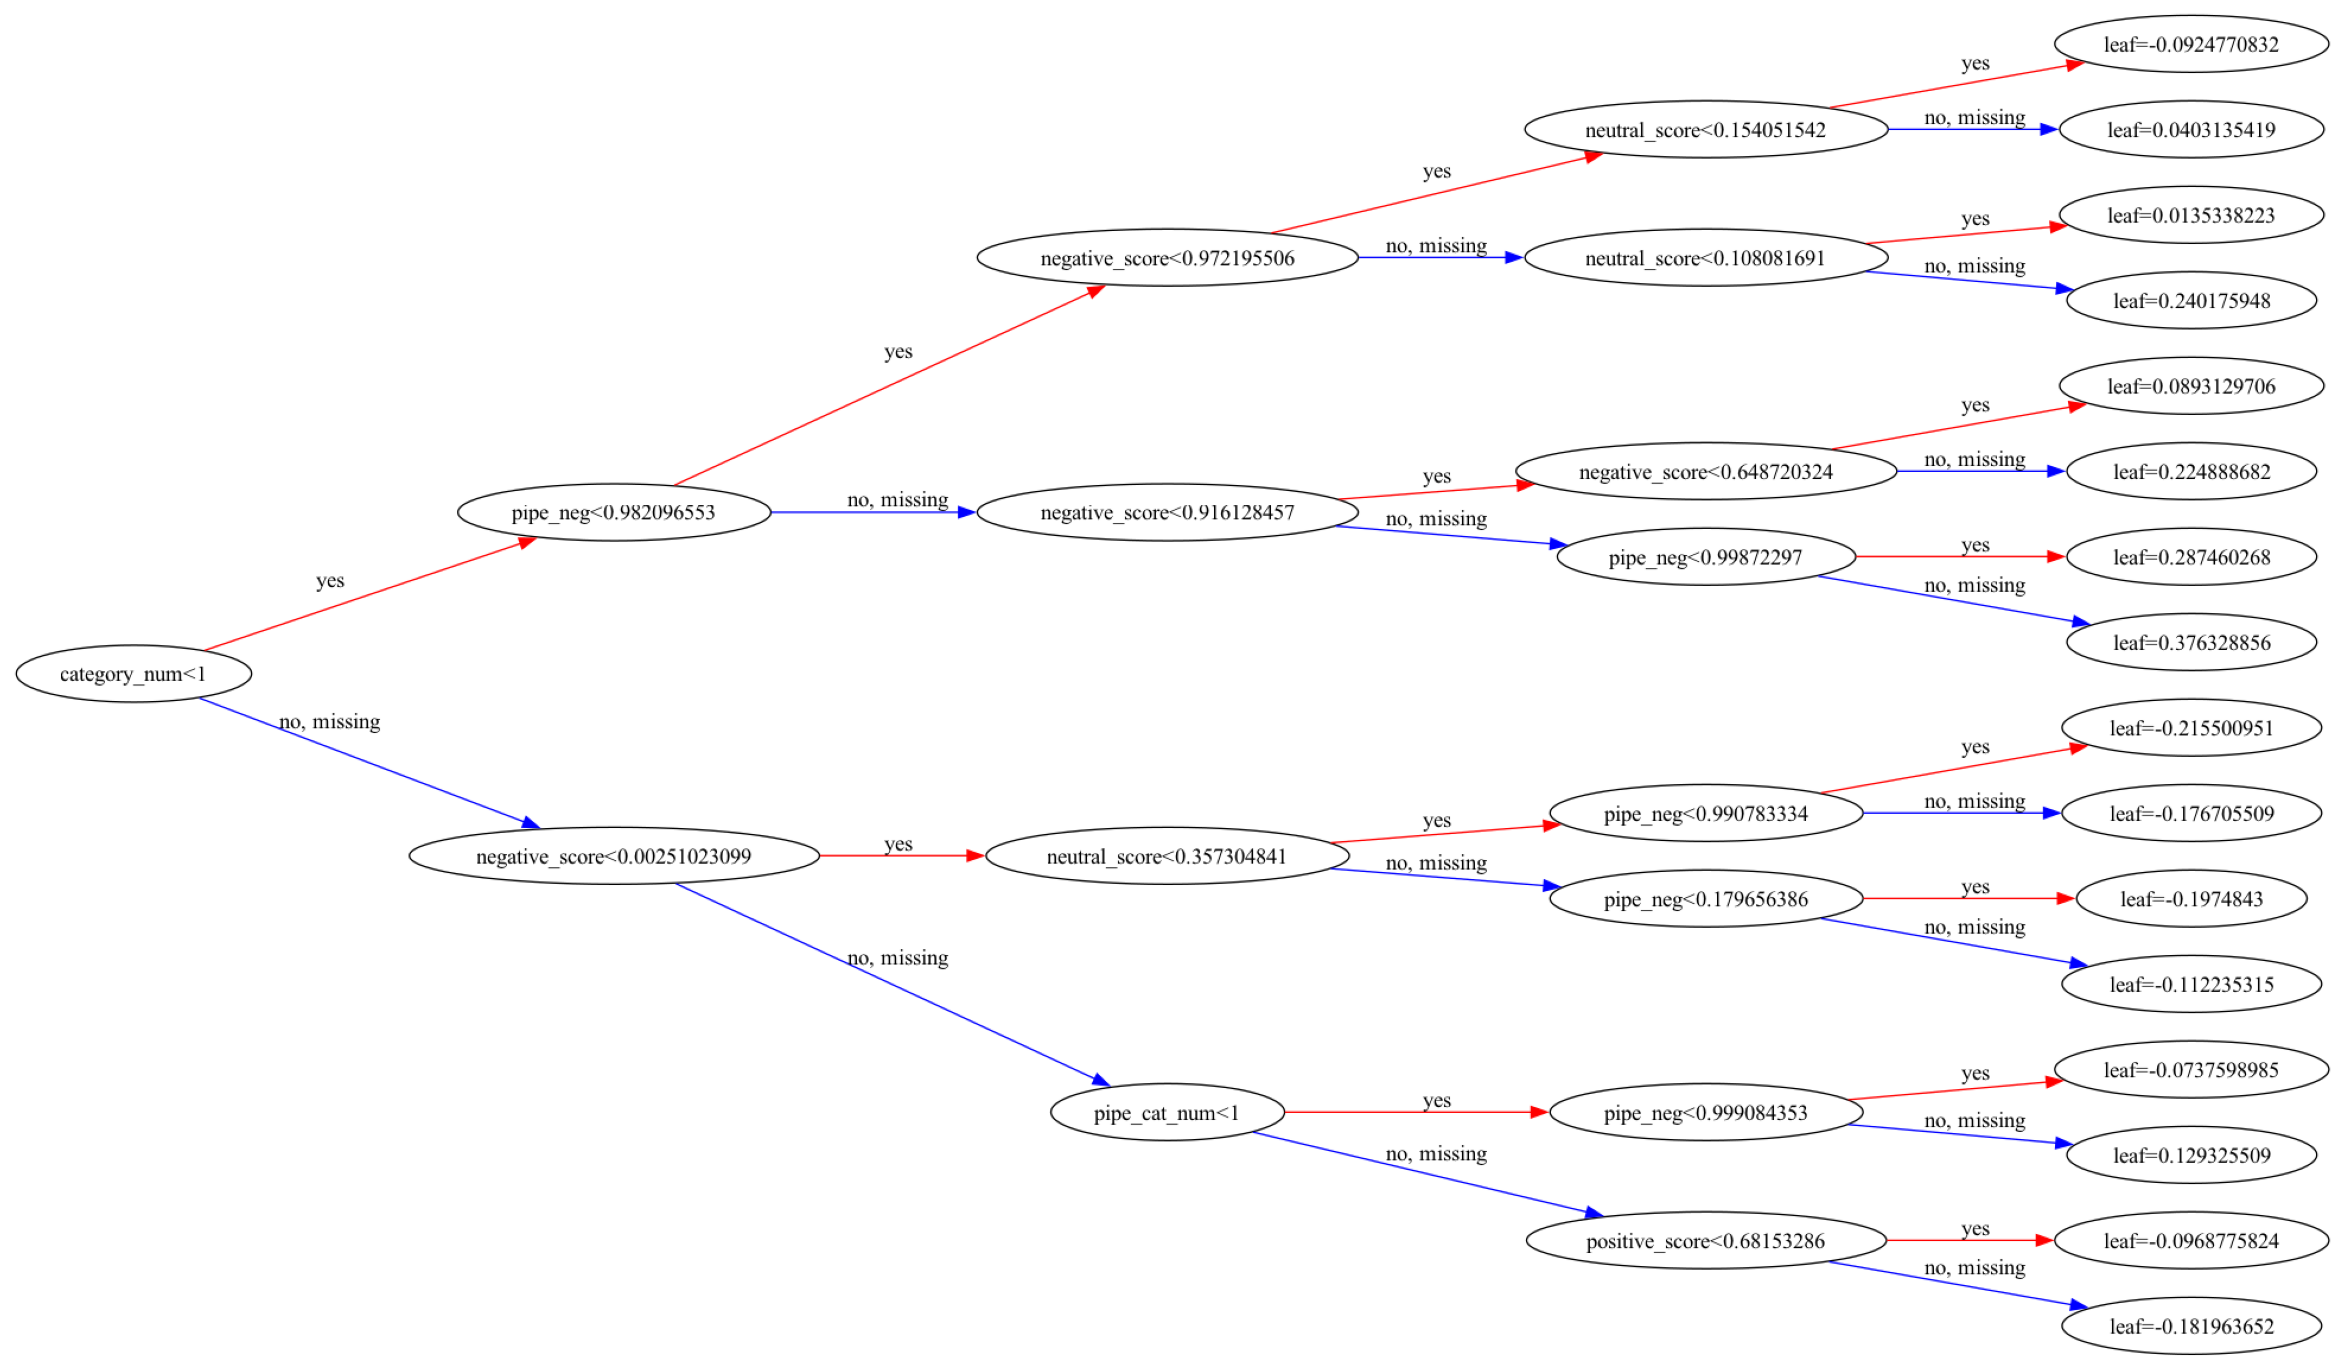

In [59]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(bst, 
          ax=ax, rankdir='LR')
plt.show()